In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import rpy2.robjects as robjects
from sklearn.preprocessing import MinMaxScaler
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter
import skdim
import os.path
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, precision_recall_curve, average_precision_score, PrecisionRecallDisplay
import umap.umap_ as umap
from tqdm import tqdm
import json
import numpy as np
import math
from scipy.stats import mannwhitneyu
from json import JSONEncoder
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from rpy2.robjects import pandas2ri
from sklearn.manifold import TSNE

#pandas2ri.activate()

In [75]:
#TO DO
# concatenare per bene
# usare https://scikit-dimension.readthedocs.io/en/latest/skdim.id.TwoNN.html#skdim.id.TwoNN 
# per stimare dimensionalita instrinseche
# poi umap per arrivare a quella dimensionalita' oppure rpca per arrivare a dimensionalita' intrinseca


# Import data

In [76]:
# import data from csv 
cnv = pd.read_csv('dataset_hg19/dataset/cnv.csv', sep=' ')

In [77]:
mirna = pd.read_csv('dataset_hg19/dataset/mirna.csv', sep=' ')

In [78]:
mrna = pd.read_csv('dataset_hg19/dataset/mrna.csv', sep=' ')

In [79]:
proteins = pd.read_csv('dataset_hg19/dataset/proteins.csv', sep=' ')

# Import label

In [80]:
label = pd.read_csv('dataset_hg19/dataset/labels_pfi.csv', sep=' ')

# Normalize data

In [81]:
def dataNormalization(scaler, data):
    scl = scaler()
    model = scl.fit(data)
    scaled_data = model.transform(data)
    
    return pd.DataFrame(scaled_data, columns=data.columns, index=data.index)

# Filter feature with low variability

In [82]:
def filter_features_with_low_variability(data, alfa) -> pd.DataFrame:
    #Delete columns with standard deviation < alfa (0.10?)
    for column in data:
        if data[column].std() < alfa:
            #print(f'column: {column} has standard deviation < {alfa}, removed')
            data.drop(column, axis=1, inplace=True)
            
    return data

# Normalize and filter datasets

In [83]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

In [84]:
def create_data_normalized_filtered(data_dict, scaler, min_variance):
    dict_filtered_nornalize = {}
    for (key, value) in zip(data_dict, data_dict.values()):
        if key != 'cnv':
            dict_filtered_nornalize[key] = filter_features_with_low_variability(dataNormalization(MinMaxScaler, value), 0.05)
        else:
            dict_filtered_nornalize[key] = value
    return dict_filtered_nornalize

# Store and retrieve data normalize and filtered

In [85]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc: # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else: raise

In [86]:
def store_filtered_normalize_data(dataset_dict):
    mkdir_p('filtered_normalize_data')
    filtered_normalize_data = create_data_normalized_filtered(dataset_dict, MinMaxScaler, 0.05)
    for data in dataset_dict:
        filtered_normalize_data[data].to_json('filtered_normalize_data/'+data+'.json')

In [87]:
def load_filtered_normalize_data(dataset_dict):
    dict_test = {}
    if os.path.exists('filtered_normalize_data'):
        for data in dataset_dict:
            with open('filtered_normalize_data/'+data+'.json', 'r') as fp:
                dataset = pd.read_json(fp)
                dict_test[data] = dataset
        return dict_test
    else:
        store_filtered_normalize_data(dataset_dict)
        load_filtered_normalize_data(dataset_dict)

In [88]:
dataset_dict = {'cnv': cnv, 'mirna': mirna, 'mrna': mrna, 'proteins': proteins}

datasets = load_filtered_normalize_data(dataset_dict)

In [89]:
print('DATI CARICATI CON SUCCESSO')

DATI CARICATI CON SUCCESSO


# Create concatenation of all dataset

In [90]:
dataset_whole_dataset = pd.concat([datasets['cnv'], datasets['proteins'], datasets['mrna'], datasets['mirna']], axis=1)

In [91]:
datasets['whole_dataset'] = dataset_whole_dataset

# Create concatenatiof dataset: proteins+mirna, proteins+mirna+mrna

In [92]:
proteins_mirna_dataset = pd.concat([datasets['proteins'], datasets['mirna']], axis=1)
datasets['proteins_mirna_dataset'] = proteins_mirna_dataset

In [93]:
proteins_mirna_mrna_dataset = pd.concat([datasets['proteins'], datasets['mirna'], datasets['mrna']], axis=1)
datasets['proteins_mirna_mrna_dataset'] = proteins_mirna_mrna_dataset

# Remove correlated feature using R code

In [94]:
robjects.r("""
install.packages('caret')
""")

R[write to console]: Installazione pacchetto in ‘/usr/local/lib/R/site-library’
(perché ‘lib’ non è specificato)

R[write to console]: apertura URL 'https://cloud.r-project.org/src/contrib/caret_6.0-93.tar.gz'

R[write to console]: Content type 'application/x-gzip'
R[write to console]:  length 2273775 bytes (2.2 MB)

R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to console]: =
R[write to con

gcc -I"/usr/share/R/include" -DNDEBUG      -fpic  -g -O2 -ffile-prefix-map=/build/r-base-Faorqz/r-base-4.2.2.20221110=. -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2  -c caret.c -o caret.o
gcc -shared -L/usr/lib/R/lib -Wl,-Bsymbolic-functions -flto=auto -ffat-lto-objects -flto=auto -Wl,-z,relro -o caret.so caret.o -L/usr/lib/R/lib -lR


** help
*** installing help indices
** building package indices
** installing vignettes
** testing if installed package can be loaded from temporary location
** checking absolute paths in shared objects and dynamic libraries
** testing if installed package can be loaded from final location
** testing if installed package keeps a record of temporary installation path
* DONE (caret)
R[write to console]: 

R[write to console]: 
R[write to console]: I pacchetti scaricati con il codice sorgente sono in
	‘/tmp/Rtmp4hw1af/downloaded_packages’
R[write to console]: 
R[write to console]: 



<rpy2.rinterface.NULLType object at 0x7f4b7cde28c0> [RTYPES.NILSXP]

In [95]:
robjects.r("""
library(doParallel)
""")

'doParall...,'parallel','iterators',...,'datasets','methods','base'


In [96]:
robjects.r("""
remove_correlated_par <- function(df, dim_split = 1000, maxiter = 5, method = "pearson", cutoff = 0.8){
  
  #df has features on columns
  X = t(df)
  niter = 0
  if (!is.finite(dim_split)) dim_split = nrow(X)
  cat("dim(X) before starting remove correlation: ", dim(X), "\n")
  while(niter < maxiter ){
    cat("niter = ", niter, '\n')
    filtered_X = NULL
    
    cl <- makeCluster(4)
    registerDoParallel(cl)
    
    filtered_X = foreach(nR = seq(1, nrow(X), by=dim_split), 
                         .combine='rbind', .packages = c("caret")) %dopar% {
                           
         subX = X[nR:min(nrow(X), (nR+dim_split-1)), ]
         cc = cor(t(subX), use = "pairwise.complete.obs", method = "kendall")
         
         select_corr = caret::findCorrelation(cc, cutoff = cutoff, exact = FALSE)
         #print(length(select_corr))
         
         if (length(select_corr)>0){ 
           subX = subX[-select_corr, ]
         }
         
         return(subX)
           
     }
    
    stopCluster(cl)
    
    print(names(filtered_X))
    #    if (length(unique(filtered_X[,1]))>1) cat('PROBLEMA!')
    no_removed = nrow(X)-nrow(filtered_X)
    cat('Removed = ', no_removed, '\n')
    cat('dim filetered_X =', dim(filtered_X), '\n')

    X = filtered_X[sample(nrow(filtered_X)), ]
    
    niter = niter + 1
    cat("nrow(X) =", dim(X), '\n')
    if (no_removed ==0) break;
  }
  cat('final dimension = ', dim(t(X)), '\n')
  
  
  return(t(X))
    }
    """)

R object with classes: ('function',) mapped to:

# Convert data in r structure data

In [97]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins = robjects.conversion.py2rpy(datasets['proteins'])

In [98]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_miRNA = robjects.conversion.py2rpy(datasets['mirna'])

In [99]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_mRNA = robjects.conversion.py2rpy(datasets['mrna'])

In [100]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_cnv = robjects.conversion.py2rpy(datasets['cnv'])

In [101]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_whole_dataset = robjects.conversion.py2rpy(datasets['whole_dataset'])

In [102]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_dataset'])

In [103]:
with localconverter(robjects.default_converter + pandas2ri.converter):
    r_proteins_mirna_mrna_dataset = robjects.conversion.py2rpy(datasets['proteins_mirna_mrna_dataset'])

# Store data in local

In [104]:
def compute_and_save_result(data, path):
    data_removed = robjects.globalenv["remove_correlated_par"](data)
    df = pd.DataFrame(data=np.array(data_removed), columns=data_removed.colnames)
    df.to_json(path)
    
def restore_result(file_name):
    return pd.read_json(f'elaborated_data_with_r_function/{file_name}.json')

def load_or_store_removed_correlated(data, file_name):
    if os.path.exists(f'elaborated_data_with_r_function/{file_name}.json'):
        return restore_result(file_name)
    else:
        compute_and_save_result(data, f'elaborated_data_with_r_function/{file_name}.json')
        return restore_result(file_name)

In [105]:
df_proteins_removed = load_or_store_removed_correlated(r_proteins, 'r_proteins_removed')

In [106]:
df_mirna_removed = load_or_store_removed_correlated(r_miRNA, 'r_mirna_removed')

In [107]:
df_mrna_removed = load_or_store_removed_correlated(r_mRNA, 'r_mrna_removed')

In [108]:
df_cnv_removed = load_or_store_removed_correlated(r_cnv, 'r_cnv_removed')

In [109]:
df_dataset_whole_dataset_removed = load_or_store_removed_correlated(r_whole_dataset, 'r_dataset_whole_dataset_removed')

In [110]:
df_dataset_proteins_mirna_removed = load_or_store_removed_correlated(r_proteins_mirna_dataset, 'r_proteins_mirna_dataset_removed')

In [111]:
df_dataset_proteins_mirna_mrna_removed = load_or_store_removed_correlated(r_proteins_mirna_mrna_dataset, 'r_proteins_mirna_mrna_dataset_removed')

In [112]:
print('DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE')

DATI MANIPOLATI CON LA FUNZIONE R ELIMINANDO LE FEATURE CORRELATE


# Intrinsic dimension estimation using the TwoNN algorithm

In [113]:
def execute_instrinsic_dimension_estimation(data):
    twoNN = skdim.id.TwoNN().fit(data)
    #estimate local intrinsic dimension (dimension in k-nearest-neighborhoods around each point):
    lpca = skdim.id.TwoNN().fit_pw(data,
                                  n_neighbors = 100,
                                  n_jobs = 1)

    #get estimated intrinsic dimension
    return twoNN.dimension_, np.mean(lpca.dimension_pw_)

In [114]:
intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(df_proteins_removed)

In [115]:
intr_dimension_mirna, _ = execute_instrinsic_dimension_estimation(df_mirna_removed)

In [116]:
intr_dimension_mrna, _ = execute_instrinsic_dimension_estimation(df_mrna_removed)

In [117]:
intr_dimension_cnv, _ = execute_instrinsic_dimension_estimation(df_cnv_removed)

In [118]:
intr_dimension_whole_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_whole_dataset_removed)

In [119]:
intr_dimension_proteins_mirna_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_proteins_mirna_removed)

In [120]:
intr_dimension_proteins_mirna_mrna_dataset, _ = execute_instrinsic_dimension_estimation(df_dataset_proteins_mirna_mrna_removed)

In [121]:
print('CALCOLATE LE DIMENSIONI INTRINSECHE')

CALCOLATE LE DIMENSIONI INTRINSECHE


# Feature extraction using t-SNE

In [122]:
def execute_tSNE(n_components, X):
    return TSNE(n_components=n_components,random_state=42, method='exact', learning_rate='auto',
               init='random', perplexity=40).fit_transform(X)

In [123]:
r_proteins_tsne = execute_tSNE(math.trunc(intr_dimension_proteins), df_proteins_removed)

r_proteins_tsne

array([[ 0.02827968, -0.538332  ,  2.017389  , ...,  0.06866251,
        -0.01419938,  0.1714379 ],
       [ 1.1858755 , -0.2449575 ,  0.09899098, ..., -0.647911  ,
        -2.2259889 ,  1.3546269 ],
       [-0.11526524,  1.1876009 , -0.25661   , ..., -0.01549989,
        -0.08914804, -0.44238356],
       ...,
       [ 0.1740745 ,  0.21492848,  0.5759676 , ..., -0.11051686,
        -0.62196606,  0.16051917],
       [ 0.41008964,  0.2961388 ,  0.06382255, ..., -0.52506596,
        -0.9969463 ,  1.3947321 ],
       [ 0.06014965,  0.05395237, -0.1184661 , ..., -0.12036185,
        -0.31327787,  0.04685224]], dtype=float32)

In [124]:
r_miRNA_tsne = execute_tSNE(math.trunc(intr_dimension_mirna), df_mirna_removed)

In [125]:
r_mRNA_tsne = execute_tSNE(math.trunc(intr_dimension_mrna), df_mrna_removed)

In [126]:
r_cnv_tsne = execute_tSNE(math.trunc(intr_dimension_cnv), df_cnv_removed)

In [127]:
r_dataset_whole_dataset_tnse = execute_tSNE(math.trunc(intr_dimension_whole_dataset), df_dataset_whole_dataset_removed)

In [128]:
r_dataset_proteins_mirna_dataset_tnse = execute_tSNE(math.trunc(intr_dimension_proteins_mirna_dataset), df_dataset_proteins_mirna_removed)

In [129]:
r_dataset_proteins_mirna_mrna_dataset_tsne = execute_tSNE(math.trunc(intr_dimension_proteins_mirna_mrna_dataset), df_dataset_proteins_mirna_mrna_removed)

In [130]:
print('ESTRATTE LE FEATURE USANDO tSNE')

ESTRATTE LE FEATURE USANDO tSNE


# Train using intrinsic dimensionality and tSNE whole dataset

In [131]:
def train_using_intrinsic_dimensionality_and_tnse_whole_dataset(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    _, ax = plt.subplots(figsize=(10, 10))
    y_score_concatenated = []
    average_precision_scores = []
    y_test_fold_concatenated = []
    result_dict = {}
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}   
    iterator = 1
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X[train_index], X[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_fold, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_fold)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_Internal.pdf')
        
        iterator = iterator +1
    
    internal_average_precision_score = np.mean(average_precision_scores)
    
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated, name='Concat of predictions')

    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
    
    return '{0:.4f}'.format(internal_average_precision_score), '{0:.4f}'.format(external_average_precision_score), clf.best_estimator_

In [132]:
model_selection_grid_DT = [
    {'criterion': ['gini', 'entropy'],
     'max_leaf_nodes': [None, 2, 5, 10],
     'max_features': [None, 'sqrt', 'log2'],
    'n_estimators': [51, 101, 251, 500]}
]

# Train proteins

('0.1359',
 '0.1083',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=2, n_estimators=51))

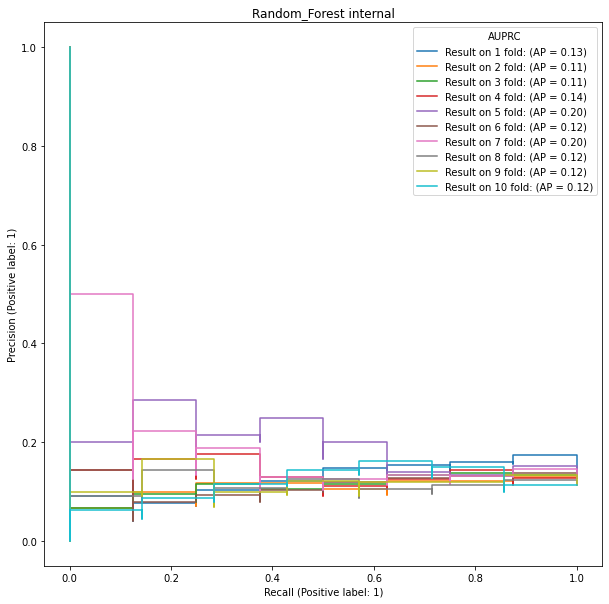

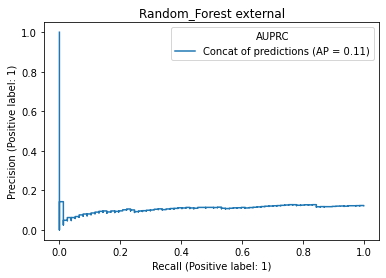

In [133]:
!mkdir 'Result/Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset'
!mkdir 'Result/Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/r_function_intrinsic_with_tsne'
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_proteins_tsne, label, 10, 'proteins', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train miRNA

('0.2057',
 '0.1533',
 RandomForestClassifier(max_features='log2', max_leaf_nodes=5, n_estimators=51))

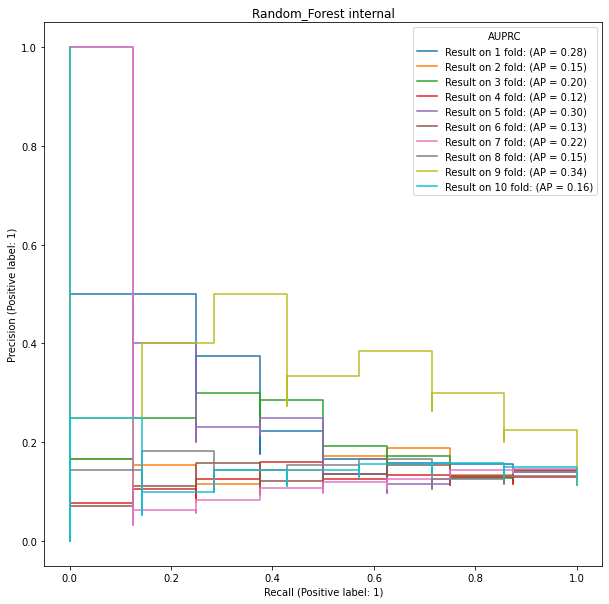

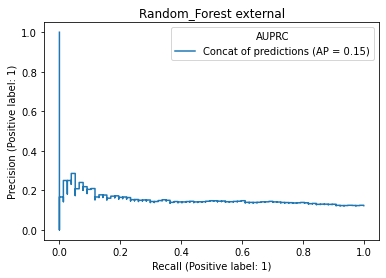

In [134]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_miRNA_tsne, label, 10, 'mirna', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train mRNA

('0.1675',
 '0.1140',
 RandomForestClassifier(max_features=None, n_estimators=51))

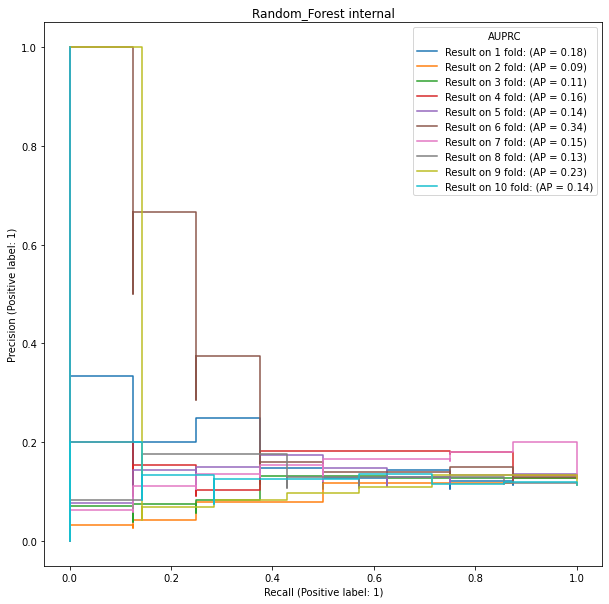

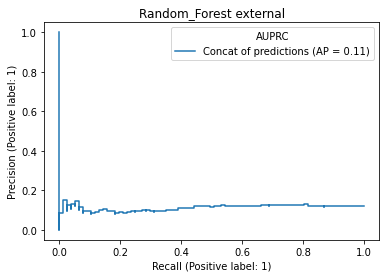

In [135]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_mRNA_tsne, label, 10, 'mrna', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train cnv

('0.1531',
 '0.1154',
 RandomForestClassifier(criterion='entropy', max_features='log2',
                        n_estimators=101))

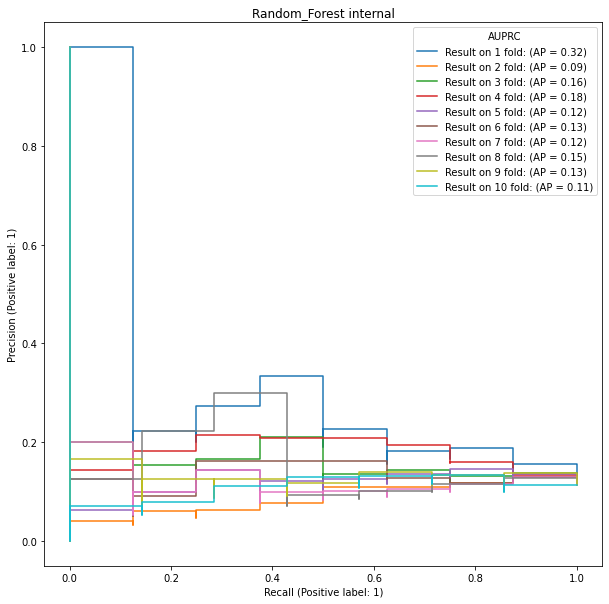

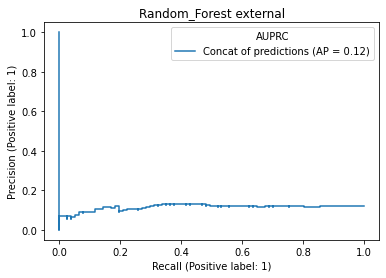

In [136]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_cnv_tsne, label, 10, 'cnv', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train whole dataset

('0.1636',
 '0.1404',
 RandomForestClassifier(max_features='log2', n_estimators=51))

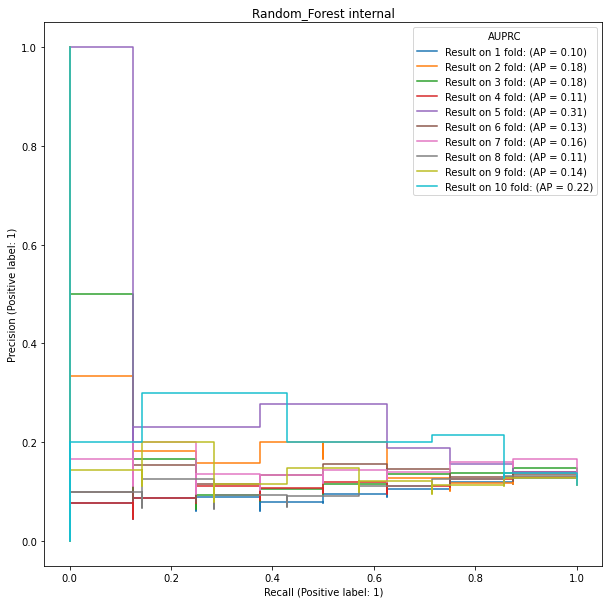

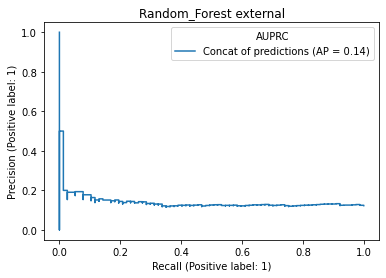

In [137]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_dataset_whole_dataset_tnse, label, 10, 'whole_dataset', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train proteins + mirna

('0.1940',
 '0.1393',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=10, n_estimators=51))

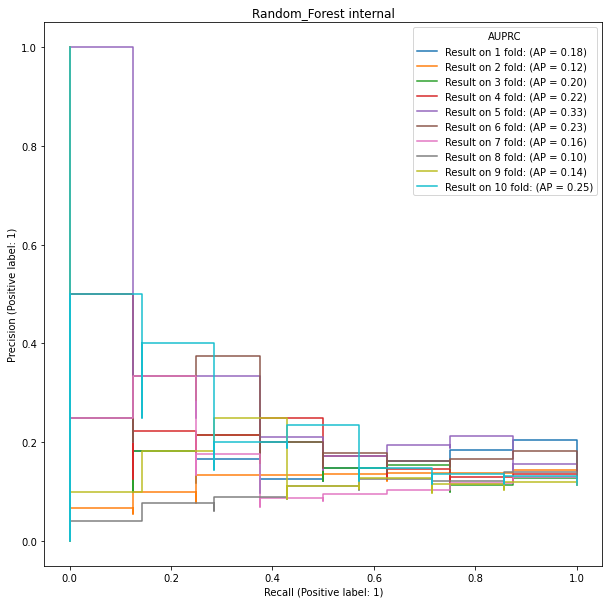

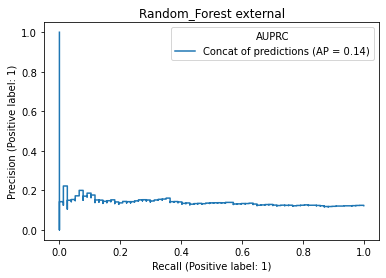

In [138]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_dataset_proteins_mirna_dataset_tnse, label, 10, 'proteins_mirna',
    'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

# Train proteins+mirna+mrna

FINITO ADDESTRAMENTO PROTEINS+MIRNA+MRNA DATASET


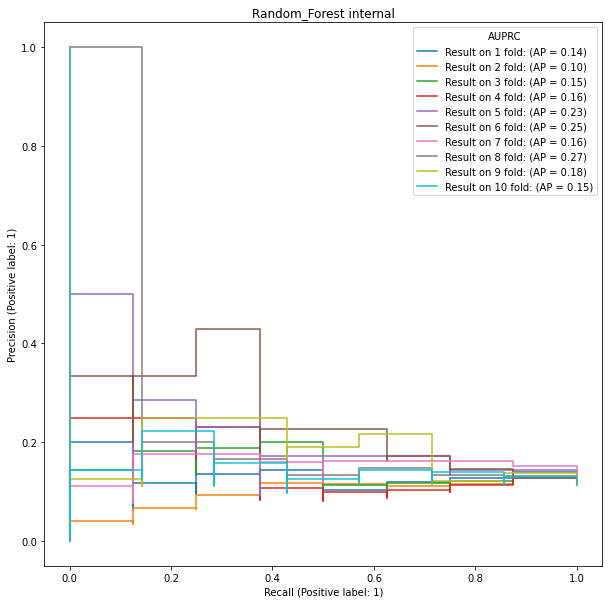

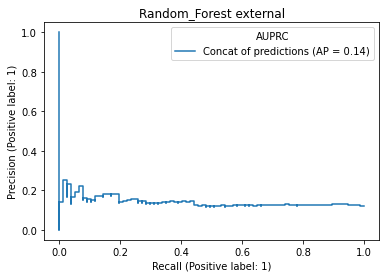

In [139]:
train_using_intrinsic_dimensionality_and_tnse_whole_dataset(
    r_dataset_proteins_mirna_mrna_dataset_tsne, label, 10, 'proteins_mirna_mrna',
    'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_intrinsic_and_tnse_whole_dataset/')

print('FINITO ADDESTRAMENTO PROTEINS+MIRNA+MRNA DATASET')

# Train using intrinsic dimensionality and tSNE on fold

In [146]:
def train_using_intrinsic_dimensionality_and_tsne_on_fold(X, label, num_external_fold,
                                          type_dataset, tecnique_feature_selection,
                                          path):
    
    """
    X : data using number of features of intrinsic dimensionality and appliying umap features extraction.
    """
    
    _, ax = plt.subplots(figsize=(10, 10))
    average_precision_scores = []
    y_score_concatenated = []
    y_test_fold_concatenated = []
    result_dict = {}
    iterator = 1
    result_dict[type_dataset] = {}
    result_dict[type_dataset][tecnique_feature_selection] = {}
    X_numpy = X.to_numpy()
    
    label_numpy = label['x'].to_numpy()
    
    external_fold = StratifiedKFold(n_splits=num_external_fold, shuffle=True, random_state=1)
    
    for train_index, test_index in tqdm(external_fold.split(X_numpy, label_numpy), desc=f"Running fold ", dynamic_ncols=True, leave=False):
        
        X_train_fold, X_test_fold = X_numpy[train_index], X_numpy[test_index]
        y_train_fold, y_test_fold = label_numpy[train_index], label_numpy[test_index]
        
        X_train_intr_dimension_proteins, _ = execute_instrinsic_dimension_estimation(X_train_fold)

        X_train_r_proteins_umap = execute_tSNE(math.trunc(X_train_intr_dimension_proteins), X_train_fold)
        X_test_r_proteins_umap = execute_tSNE(math.trunc(X_train_intr_dimension_proteins), X_test_fold)
        
        clf = GridSearchCV(estimator=RandomForestClassifier(),
                   scoring='average_precision',
                   param_grid=model_selection_grid_DT, 
                   cv=2, 
                   n_jobs=-1)
        clf.fit(X_train_r_proteins_umap, y_train_fold)
        
        # Get the predicited probability of testing data
        y_score = clf.predict_proba(X_test_r_proteins_umap)[:, 1]
        
        avg_precision_score = average_precision_score(y_test_fold, y_score)
        average_precision_scores.append(avg_precision_score)
        
        #concatenation of result for external AUPRC
        y_score_concatenated = np.concatenate((y_score_concatenated, y_score), axis=None)
        y_test_fold_concatenated = np.concatenate((y_test_fold_concatenated, y_test_fold), axis=None)
        
        
        PrecisionRecallDisplay.from_predictions(y_test_fold, y_score, ax=ax,name=f'Result on {iterator} fold:')

        plt.title('Random_Forest internal')
        ax.legend(title='AUPRC')
        plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_Internal.pdf')
        
        iterator = iterator +1
        
        
        
    internal_average_precision_score = np.mean(average_precision_scores)
    
    #plot precision recall curve
    PrecisionRecallDisplay.from_predictions(y_test_fold_concatenated, y_score_concatenated, name='Concat of predictions')

    plt.title('Random_Forest external')
    plt.legend(title='AUPRC')
    
    external_average_precision_score = average_precision_score(y_test_fold_concatenated, y_score_concatenated)
    
    result_dict[type_dataset][tecnique_feature_selection]['internal'] = '{0:.4f}'.format(internal_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['external'] = '{0:.4f}'.format(external_average_precision_score)
    result_dict[type_dataset][tecnique_feature_selection]['best_estimator'] = str(clf.best_estimator_)
    
    plt.savefig('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'_'+'AUPRC_External.pdf')
    
    with open('Result/'+path+tecnique_feature_selection+'/'+type_dataset+'.json', 'w', encoding='utf-8') as fp:
        json.dump(result_dict[type_dataset], fp, ensure_ascii=False, indent=4)
        
    
    return '{0:.4f}'.format(internal_average_precision_score), '{0:.4f}'.format(external_average_precision_score), clf.best_estimator_

# Train proteins

mkdir: impossibile creare la directory "Result/Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold": File già esistente


('0.1992', '0.1415', RandomForestClassifier(max_leaf_nodes=5, n_estimators=51))

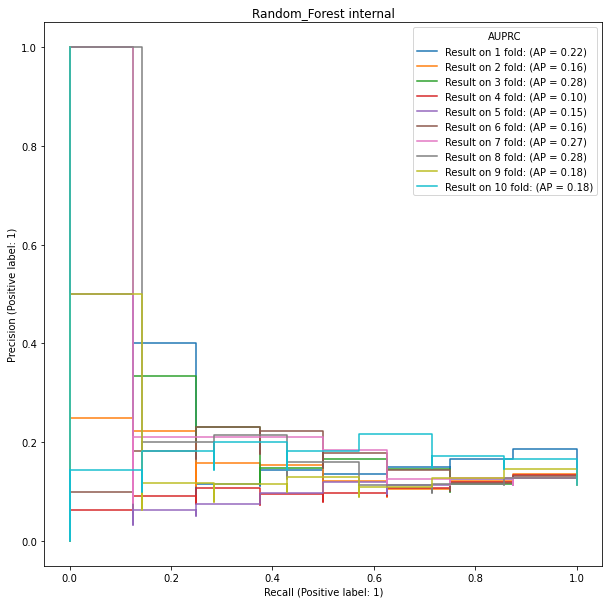

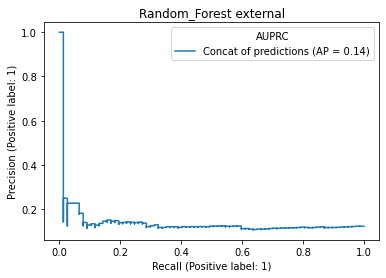

In [142]:
!mkdir 'Result/Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold'
!mkdir 'Result/Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/r_function_intrinsic_with_tsne'

train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_proteins_removed, label, 10, 'proteins', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train mrna

('0.1846',
 '0.1302',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=5, n_estimators=51))

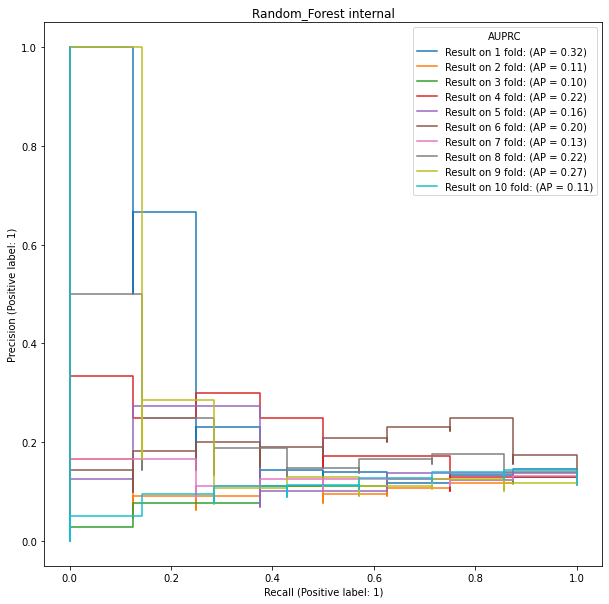

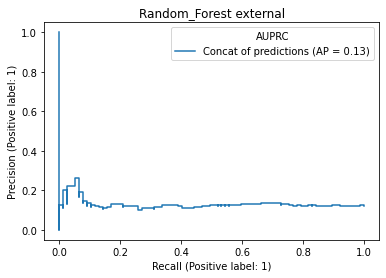

In [143]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_mrna_removed, label, 10, 'mrna', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train mirna

('0.1600', '0.1253', RandomForestClassifier(max_leaf_nodes=5, n_estimators=51))

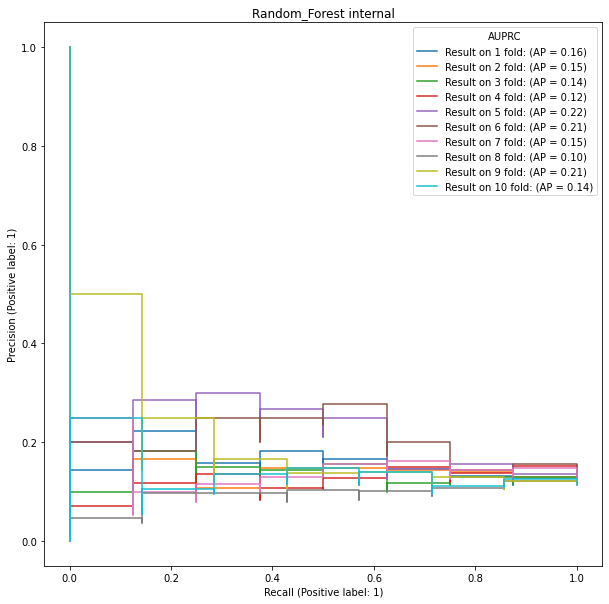

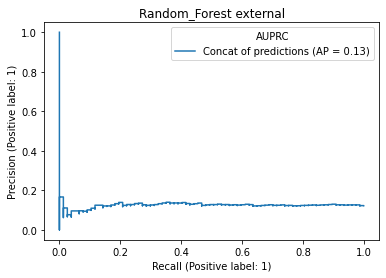

In [144]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_mirna_removed, label, 10, 'mirna', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train cnv

('0.1632', '0.1124', RandomForestClassifier(max_leaf_nodes=2, n_estimators=51))

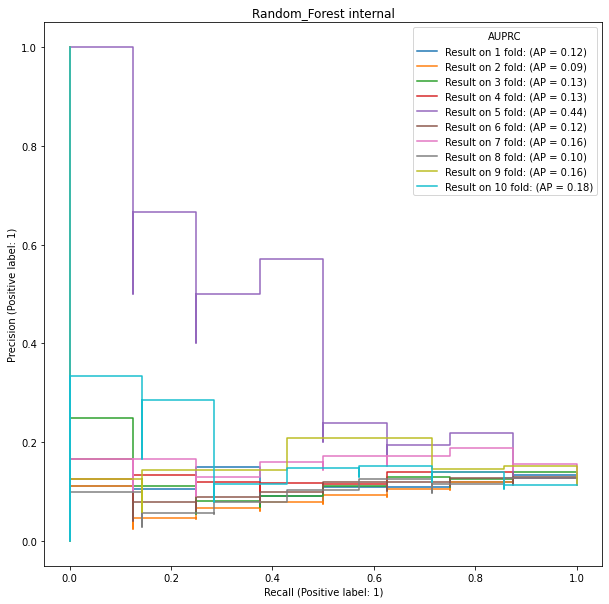

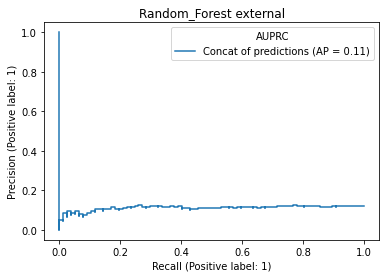

In [147]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_cnv_removed, label, 10, 'cnv', 'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train whole dataset

('0.1635', '0.1390', RandomForestClassifier(max_leaf_nodes=2, n_estimators=51))

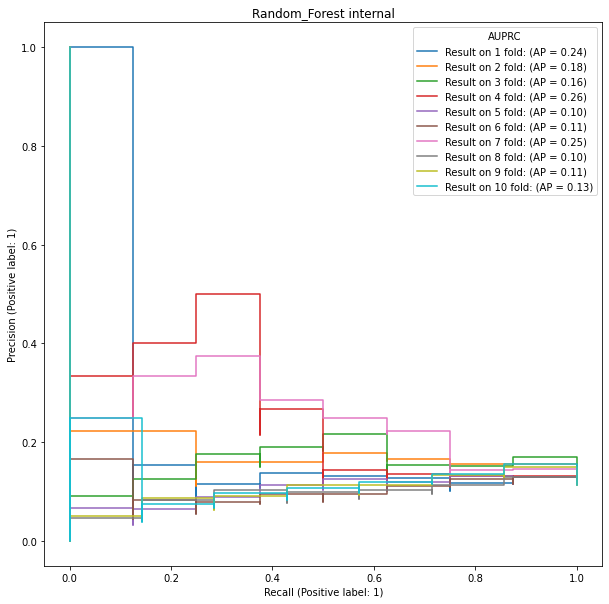

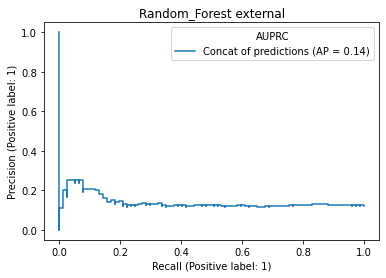

In [150]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_dataset_whole_dataset_removed, label, 10, 'whole_dataset',
    'r_function_intrinsic_with_tsne', 
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train proteins + mirna

('0.1770',
 '0.1242',
 RandomForestClassifier(criterion='entropy', max_features=None, max_leaf_nodes=5,
                        n_estimators=51))

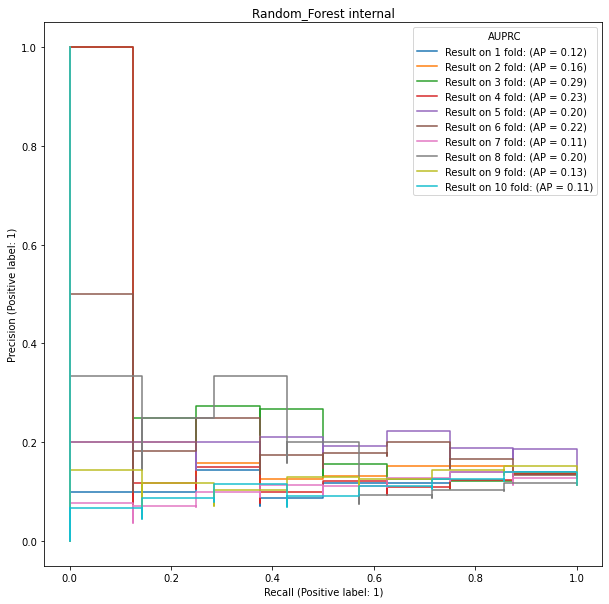

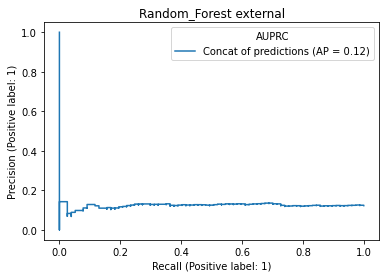

In [151]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_dataset_proteins_mirna_removed, label, 10, 'proteins_mirna',
    'r_function_intrinsic_with_tsne',
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')

# Train proteins + mirna+mrna

('0.1601',
 '0.1238',
 RandomForestClassifier(criterion='entropy', max_leaf_nodes=10, n_estimators=101))

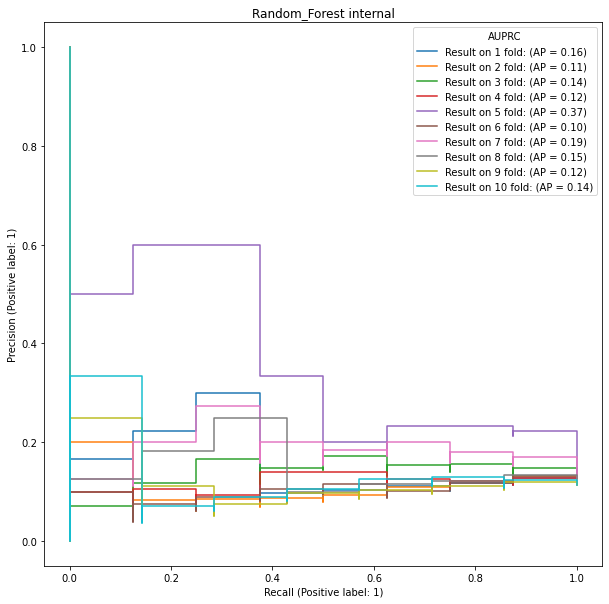

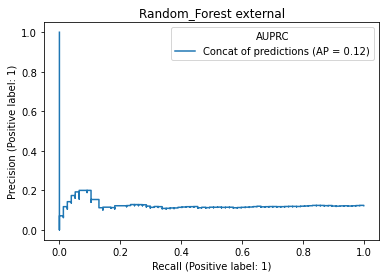

In [152]:
train_using_intrinsic_dimensionality_and_tsne_on_fold(
    df_dataset_proteins_mirna_mrna_removed, label, 10, 'proteins_mirna_mrna',
    'r_function_intrinsic_with_tsne', 
    'Experiments_using_R_Function_whole_intrinsic_and_tsne_on_fold/')